# Summary

This notebook is for analyzing the outcome model fitting time and accuracy across different multi-output GP methods

In [2]:
%load_ext autoreload
%autoreload 2

import itertools
import pickle
import re
import warnings
from collections import defaultdict
from dataclasses import asdict, dataclass
from typing import Dict, List, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import seaborn as sns
import torch 

warnings.filterwarnings("ignore")

import sys
sys.path.append('..')

/home/yz685/anaconda3/envs/bope_pca/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
colors_dict = {
    "pca": "tab:red", 
    "pcr": "tab:cyan", 
    "st": "tab:blue", 
    "random_linear_proj": "tab:green", 
    "random_subset": "tab:orange", 
    "mtgp": "tab:purple", 
    "lmc": "tab:pink",
    "lmc2": "tab:brown"
}

# Final utility model accuracy

In [6]:
fitting_times = defaultdict(dict)
mses = defaultdict(dict)

for outcome_dim in [10, 20, 30, 40]:
    for trial in range(101, 121):
        try:
            fitting_times[outcome_dim][trial] = torch.load(
                f'/home/yz685/low_rank_BOPE/experiments/synthetic/test_model_fit_outcome_dim={outcome_dim}/fitting_time_dict_trial={trial}.th')
            mses[outcome_dim][trial] = torch.load(
                f'/home/yz685/low_rank_BOPE/experiments/synthetic/test_model_fit_outcome_dim={outcome_dim}/mse_dict_trial={trial}.th')
        except:
            print(outcome_dim, trial, 'loading failed')
            continue

40 116 loading failed
40 119 loading failed
40 120 loading failed


In [33]:
# keys are (outcome dim, trial index, data size)
fitting_times[10][101][100]

{'st': 27.942320346832275,
 'pca': 4.139376878738403,
 'lmc': 83.40475988388062,
 'mtgp': 459.33301877975464}

In [67]:


def plot_time(data_size, outcome_dims = [10,20,30,40], trial_range = range(101,111)):

    time_mean = defaultdict(dict)
    time_sem = defaultdict(dict)

    for outcome_dim in outcome_dims:
        values=[]
        for trial in trial_range:
            if trial in fitting_times[outcome_dim].keys():
                values.append(fitting_times[outcome_dim][trial][data_size])
        # values = [fitting_times[outcome_dim][trial][data_size] for trial in trial_range]
        print("amount of trials available: ", sum(v != {} for v in values))

        df = pd.DataFrame(values)
        if not df.empty:
            mean = df.mean(axis=0)
            sem = df.sem(axis=0)
            for method in mean.index.values:
                time_mean[method][outcome_dim] = mean[method]
                time_sem[method][outcome_dim] = 1.96*sem[method]
            # print(time_sem)
            # time_by_outcome_dim[outcome_dim] = (mean, sem)

    for method in ["st", "pca", "mtgp", "lmc"]:
        plt.plot(
            list(time_mean[method].keys()), 
            list(time_mean[method].values()), 
            label=method, 
            color=colors_dict[method],
            marker='o'
        )
        plt.errorbar(
            list(time_mean[method].keys()), 
            list(time_mean[method].values()), 
            list(time_sem[method].values()),
            color=colors_dict[method]
        )

    plt.legend()
    plt.title(f"Outcome model fitting time for data size={data_size}")
    plt.xlabel("Outcome model")
    plt.ylabel("Fitting time (seconds)")

amount of trials available:  10
amount of trials available:  10
amount of trials available:  9
amount of trials available:  0


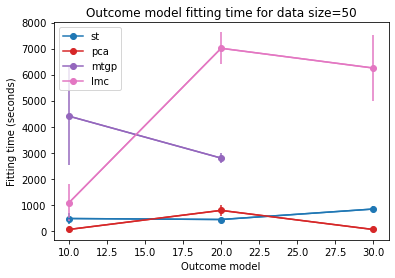

In [71]:
plot_time(50, trial_range=range(101,111))

In [23]:
def plot_mse(data_size, outcome_dims = [10,20,30,40], trial_range = range(101,111)):

    mse_mean = defaultdict(dict)
    mse_sem = defaultdict(dict)

    for outcome_dim in outcome_dims:
        values=[]
        for trial in trial_range:
            if trial in mses[outcome_dim].keys():
                values.append(mses[outcome_dim][trial][data_size])
        # values = [mses[outcome_dim][trial][data_size] for trial in trial_range]
        print("amount of trials available: ", sum(v != {} for v in values))

        df = pd.DataFrame(values)
        if not df.empty:
            for method in ["st", "pca", "lmc", "mtgp"]:
                df[method] = np.log(df[method])
            mean = df.mean(axis=0)
            # sem = df.sem(axis=0)
            # print(mean, sem)
            # mse_by_outcome_dim[outcome_dim] = (mean, sem)
            std = df.std(axis=0)
            for method in mean.index.values:
                mse_mean[method][outcome_dim] = mean[method]
                mse_sem[method][outcome_dim] = 1.96*std[method]
            

    for method in ["st", "pca", "mtgp", "lmc"]:
        plt.plot(
            list(mse_mean[method].keys()), 
            list(mse_mean[method].values()), 
            label=method, 
            color=colors_dict[method],
            marker='o'
        )
        plt.errorbar(
            list(mse_mean[method].keys()), 
            list(mse_mean[method].values()), 
            list(mse_sem[method].values()),
            color=colors_dict[method]
        )

    plt.legend()
    plt.title(f"Outcome model fitting log relative MSE for data size={data_size}")
    plt.xlabel("Outcome model")
    plt.ylabel("Log relative MSE")

amount of trials available:  10
amount of trials available:  10
amount of trials available:  8
amount of trials available:  7
outcome dim:  10
outcome dim:  20
outcome dim:  30
outcome dim:  40


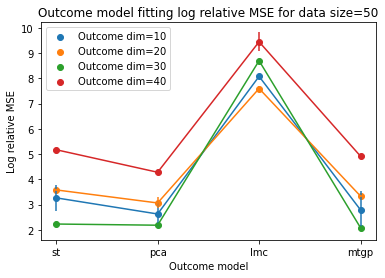

In [24]:
plot_mse(50, trial_range = range(111,121))

In [18]:
plot_mse(100, trial_range = range(111,121))

amount of trials available:  10
amount of trials available:  10
amount of trials available:  8
amount of trials available:  4


KeyError: 'lmc'

In [84]:
mse_by_outcome_dim = {}

for outcome_dim in [10, 20, 30, 40]:
    values = [mses[outcome_dim][trial][50] for trial in range(101, 111)]
    print("amount of trials available: ", sum(v != {} for v in values))

    df = pd.DataFrame(values)
    # print(df)
    if not df.empty:
        for method in ["st", "pca", "lmc", "mtgp"]:
            df[method] = np.log(df[method])
        mean = df.mean(axis=0)
        sem = df.sem(axis=0)
        # print(mean, sem)
        mse_by_outcome_dim[outcome_dim] = (mean, sem)

amount of trials available:  10
amount of trials available:  10
amount of trials available:  9
amount of trials available:  0


outcome dim:  10
outcome dim:  20
outcome dim:  30
outcome dim:  40
Data not complete, skipping for now


Text(0, 0.5, 'Log relative MSE')

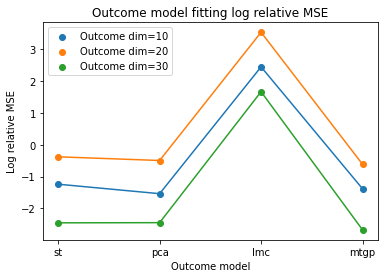

In [87]:
for outcome_dim in [10,20,30,40]:

    print("outcome dim: ", outcome_dim)

    if outcome_dim not in mse_by_outcome_dim or len(mse_by_outcome_dim[outcome_dim][0]) == 0:
        print("Data not complete, skipping for now")
        continue

    elif len(mse_by_outcome_dim[outcome_dim][0]) != 0: 
        
        plt.scatter(['st', 'pca', 'lmc', 'mtgp'], mse_by_outcome_dim[outcome_dim][0],label=f"Outcome dim={outcome_dim}")
        plt.errorbar(['st', 'pca', 'lmc', 'mtgp'], mse_by_outcome_dim[outcome_dim][0], mse_by_outcome_dim[outcome_dim][1])



plt.legend()
plt.title("Outcome model fitting log relative MSE")
plt.xlabel("Outcome model")
plt.ylabel("Log relative MSE")

# Deprecated, plot with method on x axis


def plot_time(data_size, outcome_dims = [10,20,30,40], trial_range = range(101,111)):

    time_by_outcome_dim = {}

    for outcome_dim in outcome_dims:
        values=[]
        for trial in trial_range:
            if trial in fitting_times[outcome_dim].keys():
                values.append(fitting_times[outcome_dim][trial][data_size])
        # values = [fitting_times[outcome_dim][trial][data_size] for trial in trial_range]
        print("amount of trials available: ", sum(v != {} for v in values))

        df = pd.DataFrame(values)
        if not df.empty:
            mean = df.mean(axis=0)
            sem = df.sem(axis=0)
            # print(mean, sem)
            time_by_outcome_dim[outcome_dim] = (mean, sem)

    for outcome_dim in outcome_dims:

        print("outcome dim: ", outcome_dim)
        

        if outcome_dim not in time_by_outcome_dim:
            # print(time_by_outcome_dim[outcome_dim][0].index.values)
            
            print("Data not complete, skipping for now")
            continue    

        else: 
            
            plt.scatter(time_by_outcome_dim[outcome_dim][0].index.values, time_by_outcome_dim[outcome_dim][0],label=f"Outcome dim={outcome_dim}")
            plt.errorbar(time_by_outcome_dim[outcome_dim][0].index.values, time_by_outcome_dim[outcome_dim][0], time_by_outcome_dim[outcome_dim][1])


    plt.legend()
    plt.title(f"Outcome model fitting time for data size={data_size}")
    plt.xlabel("Outcome model")
    plt.ylabel("Fitting time (seconds)")